In [69]:
import os
import copy
from IPython.display import HTML

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import splev,splrep
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
from matplotlib import animation
import seaborn as sns
import astropy.units as u
import hissw
from sunpy.map import Map,MapCube
from sunpy.visualization.mapcubeanimator import MapCubeAnimator
import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.atomic import EmissionModel

%matplotlib inline

# Emission Measure Analysis: Idealized Dipole Active Region
Compute the emission measure distribution using synthesized AIA images of an idealized dipole "active region." This time, we've computed the AIA emission using *all* of the ions in the CHIANTI atomic database.

## Select Region
First, we need to look at an example image and select a region to perform the inversion routine over.

In [60]:
example_map = Map('/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/SDO_AIA/171/map_t000000.fits')

In [61]:
width,height = 75*u.arcsec,2*u.arcsec
left_x,bottom_y = 5*u.arcsec - width/2.,-30*u.arcsec - height/2.

In [62]:
left_x_pixel,bottom_y_pixel = example_map.data_to_pixel(left_x,bottom_y)
right_x_pixel,top_y_pixel = example_map.data_to_pixel(left_x + width,bottom_y + height)

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/map/mapbase.py:1593: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


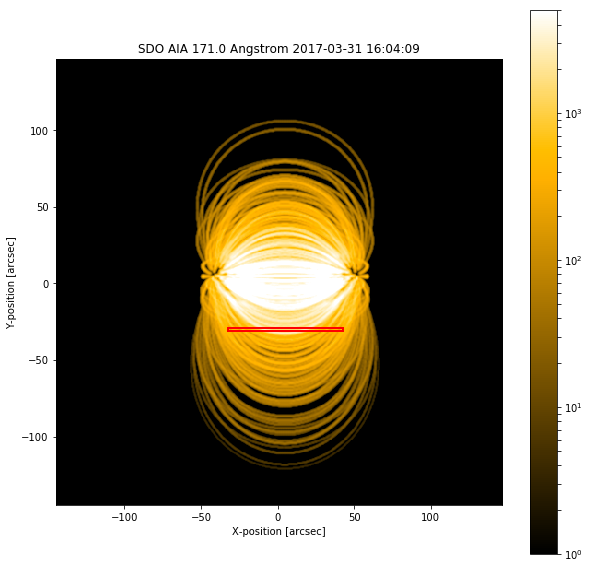

In [63]:
fig = plt.figure(figsize=(10,10))
im = example_map.plot(axes=fig.gca(),
                      norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1e0,vmax=5e3)
                     )
example_map.draw_rectangle(u.Quantity([left_x.value,bottom_y.value],left_x.unit),
                           width,height,
                           color='r',lw=2)
fig.colorbar(im)

In [64]:
u.Unit(example_map.meta['bunit'])

Unit("ct / (pix s)")

## Run EM Inversion Code

Instantiate the SSW runner and set some variables.

In [41]:
demreg_runner = hissw.ScriptMaker(ssw_pkg_list=['sdo/aia'],ssw_path_list=['aia','vobs','ontology'],
                                  extra_paths=['/home/wtb2/Documents/codes/demreg/idl/',
                                               '../scripts/'])

In [42]:
aia_file_format = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/SDO_AIA/*/map_t{time:06d}.fits'
aia_file_format_tresponse = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/use_temperature_response_functions/SDO_AIA/*/map_t{time:06d}.fits'

In [43]:
input_vars = {'x1':int(left_x_pixel.value),
              'x2':int(right_x_pixel.value),
              'y1':int(bottom_y_pixel.value),
              'y2':int(top_y_pixel.value),
              'demreg_path':'/home/wtb2/Documents/codes/demreg/',
              'dt':10.,
              'n_T':int(50),'T0':5.7,'T1':7.15
             }

In [44]:
save_vars = ['logtemps','mlogt','dem','edem','dn','edn','TRmatrix','tr_logt']

Create the script to run the inversion function.

In [45]:
runner_script = """
tt ={{T0}}+findgen({{n_T}})*({{T1}} - {{T0}})/({{n_T}} - 1)
aia_file_format = '{{aia_file_format}}'
demreg_path = '{{demreg_path}}'
x1 = {{x1}}
x2 = {{x2}}
y1 = {{y1}}
y2 = {{y2}}
dt = {{dt}}
calculate_dem_1d,tt,aia_file_format,demreg_path,x1,x2,y1,y2,dt,logtemps,mlogt,dem,edem,dn,edn,tr_logt,trmatrix
"""

In [46]:
aia = InstrumentSDOAIA([3e3,8e3]*u.s)

Create a data structure for holding information about inversion.

In [47]:
class DEMResults(object):
    def __init__(self,data,time):
        self.time = time
        self.temperature = 10.**data['logtemps']
        self.temperature_bin_centers = 10.**data['mlogt']
        self.dem = data['dem']
        self.em = data['dem']*np.diff(self.temperature)
        self.dem_errors = data['edem']
        self.em_errors = data['edem']*np.diff(self.temperature)
        self.tresponse = data['TRmatrix']
        self.tresponse_temperature = 10.**data['tr_logt']
        self.counts = data['dn']
        
    def fit_cool(self,logTa=6.0,logTb=6.6):
        def linear_fit(x,a,b):
            return a*x + b
        interval_index = np.where(np.logical_and(np.log10(self.temperature)>=logTa,
                                                 np.log10(self.temperature)<=logTb))
        if len(interval_index[0]) == 0:
            raise ValueError('No fit possible')
        logT_fit = np.log10(self.temperature[interval_index[0]])
        logEM_fit = np.log10(self.em[interval_index[0]])
        popt,popcov = curve_fit(linear_fit,logT_fit,logEM_fit)
        
        self.a = popt[0]
        self.fit_x = 10.**logT_fit
        self.fit_y = (10.**(popt[1]))*self.fit_x**self.a

Run the inversion at each timestep

In [48]:
idealized_dem = []
idealized_dem_tresponse = []

In [49]:
for t in aia.observing_time[0:20]:
    print('Processing DEM for t = {}'.format(t))
    # w/o temperature response functions
    input_vars['aia_file_format'] = aia_file_format.format(time=np.where(aia.observing_time==t)[0][0])
    tmp = demreg_runner.run([(runner_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=False)
    tmp_dem = DEMResults(tmp,t)
    #try:
    #    tmp_dem.fit_cool(logTa=6.0,logTb=6.4)
    #except ValueError:
    #    pass
    idealized_dem.append(copy.deepcopy(tmp_dem))
    # w/ temperature response functions
    input_vars['aia_file_format'] = aia_file_format_tresponse.format(time=np.where(aia.observing_time==t)[0][0])
    tmp = demreg_runner.run([(runner_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=False)
    tmp_dem = DEMResults(tmp,t)
    idealized_dem_tresponse.append(copy.deepcopy(tmp_dem))

Processing DEM for t = 3000.0 s
Processing DEM for t = 3010.0 s
Processing DEM for t = 3020.0 s
Processing DEM for t = 3030.0 s
Processing DEM for t = 3040.0 s
Processing DEM for t = 3050.0 s
Processing DEM for t = 3060.0 s
Processing DEM for t = 3070.0 s
Processing DEM for t = 3080.0 s
Processing DEM for t = 3090.0 s
Processing DEM for t = 3100.0 s
Processing DEM for t = 3110.0 s
Processing DEM for t = 3120.0 s
Processing DEM for t = 3130.0 s
Processing DEM for t = 3140.0 s
Processing DEM for t = 3150.0 s
Processing DEM for t = 3160.0 s
Processing DEM for t = 3170.0 s
Processing DEM for t = 3180.0 s
Processing DEM for t = 3190.0 s


(1e+25, 2e+30)

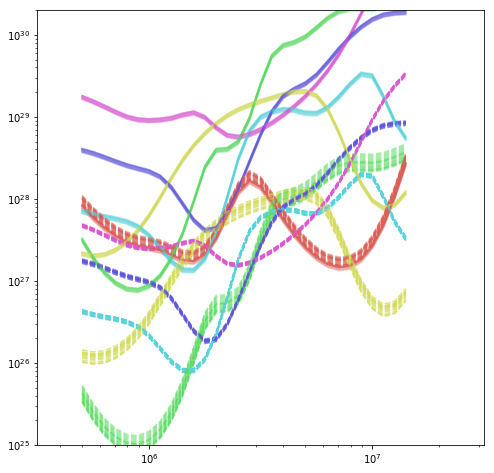

In [51]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
colormap = plt.cm.viridis
channel_colors = sns.color_palette('hls',len(idealized_dem[0].counts))
for i in range(len(aia.observing_time[0:20])):
    #ax.step(idealized_dem[i].temperature[1:],
    #        idealized_dem[i].em,
    #        color='b',alpha=.2)
    #ax.step(idealized_dem_tresponse[i].temperature[1:],
    #        idealized_dem_tresponse[i].em,
    #        color='r',alpha=.2)
    for j in range(len(idealized_dem_tresponse[i].counts)):
        #if i==0:
        ax.plot(idealized_dem_tresponse[i].tresponse_temperature,
                idealized_dem_tresponse[i].counts[j]/idealized_dem_tresponse[i].tresponse[j,:],
                color=channel_colors[j],linestyle='--',label=aia.channels[j]['name'],
                alpha=0.5)
        ax.plot(idealized_dem[i].tresponse_temperature,
                idealized_dem[i].counts[j]/idealized_dem[i].tresponse[j,:],
                color=channel_colors[j],linestyle='-',alpha=0.2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10.**(5.5),10.**(7.5)])
ax.set_ylim([1e25,2e30])
#ax.legend(loc='lower right',fontsize=18)

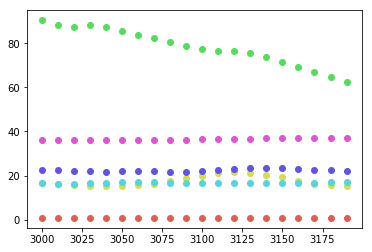

In [52]:
for i in range(len(aia.observing_time[0:20])):
    for c,ct,color in zip(idealized_dem[i].counts,idealized_dem_tresponse[i].counts,channel_colors):
        plt.plot(aia.observing_time[0:20][i],c/ct,color=color,marker='o')
        #plt.plot(aia.observing_time[0:20][i],ct,color=color,marker='*')
#plt.yscale('log')

## Fractional Ionization Tests

In [ ]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

In [ ]:
field_control = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/field_checkpoint/')

In [ ]:
loop_number = 200
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax_n = ax.twinx()
for i in range(len(field_control.loops[loop_number].time)-1):
    ax.plot(field_control.loops[loop_number].temperature[i:i+2,0],
             field_control.loops[loop_number].get_fractional_ionization('Fe',13)[i:i+2,0],
             color=plt.cm.viridis(i/len(field_control.loops[loop_number].time)),
             marker='*',linestyle='',markersize=10,alpha=0.2)
for i in range(len(field_control.loops[loop_number].time)-1):
    ax_n.plot(field_control.loops[loop_number].temperature[i:i+2,0],
             field_control.loops[loop_number].density[i:i+2,0],
             color=plt.cm.viridis(i/len(field_control.loops[loop_number].time)),
             lw=3,linestyle='-',alpha=1.)
ax.set_xscale('log')
ax_n.set_xscale('log')
ax_n.set_yscale('log')
ax.set_ylim([-0.1,1])
ax.set_xlim([1e5,2e7])
ax_n.set_xlim([1e5,5e7])
ax_n.set_ylim([1e7,3e10])
#field_control.loops[0].fractional_ionization_savefile

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
#j=9
for j in range(2,26):
    for i in range(len(field_control.loops[loop_number].time)-1):
        ax.plot(np.log10(field_control.loops[loop_number].temperature[i:i+2,0].value),
                field_control.loops[loop_number].get_fractional_ionization('Fe',j)[i:i+2,0],
                field_control.loops[loop_number].time[i:i+2].value,
                color=plt.cm.viridis(j/27))
ax.view_init(elev=30,azim=70)
ax.set_ylim([0,1])

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i,ion in enumerate(emission_model.ions):
    if ion.chianti_ion.meta['Element'] != 'Fe':
        continue
    
    print(ion.chianti_ion.meta['name'])
    nots = splrep(emission_model.temperature_mesh[:,0].value,
                  ion.chianti_ion.equilibrium_fractional_ionization.reshape(emission_model.temperature_mesh.shape)[:,0])
    #for loop in field_control.loops:
    loop = field_control.loops[200]
    # NEI
    ax.plot(loop.time,loop.get_fractional_ionization(ion.chianti_ion.meta['Element'],
                                                                 ion.chianti_ion.meta['Ion'])[:,0],
            color=plt.cm.viridis(i),
            alpha=0.5,linestyle='-')
    # IEQ
    ioneq = splev(loop.temperature[:,0].value,nots,ext=1)
    ax.plot(loop.time,ioneq,
            color=plt.cm.viridis(i),
            alpha=0.5,linestyle='--')
ax_T = ax.twinx()
ax_T.plot(loop.time,loop.temperature[:,0],'k')
#ax.set_xscale('log')
ax.set_ylim([0,1])

## Control Group Test
Run the emission on our control group where we've let our AR cool over a period of 5000 s.

In [ ]:
example_map_control = Map('/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/SDO_AIA/171/map_t000200.fits')

In [ ]:
width,height = 10*u.arcsec,10*u.arcsec
left_x,bottom_y = 5*u.arcsec - width/2.,10*u.arcsec - height/2.

In [ ]:
left_x_pixel,bottom_y_pixel = example_map_control.data_to_pixel(left_x,bottom_y)
right_x_pixel,top_y_pixel = example_map_control.data_to_pixel(left_x + width,bottom_y + height)

In [ ]:
fig = plt.figure(figsize=(10,10))
im = example_map_control.plot(axes=fig.gca(),
                      norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1e0,vmax=1e5)
                     )
example_map_control.draw_rectangle(u.Quantity([left_x.value,bottom_y.value],left_x.unit),
                           width,height,
                           color='r',lw=2)
fig.colorbar(im)

In [ ]:
aia_control = InstrumentSDOAIA([0,5e3]*u.s)

In [ ]:
input_vars = {'x1':int(left_x_pixel.value),
              'x2':int(right_x_pixel.value),
              'y1':int(bottom_y_pixel.value),
              'y2':int(top_y_pixel.value),
              'demreg_path':'/home/wtb2/Documents/codes/demreg/',
              'dt':10.,
              'n_T':int(30),'T0':5.7,'T1':7.15,
             }
save_vars = ['logtemps','mlogt','dem','edem','dn','edn','TRmatrix','tr_logt']

In [ ]:
aia_ff_control = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/SDO_AIA/*/map_t{time:06d}.fits'
aia_ff_control_tresponse = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole_control/use_temperature_response_functions/SDO_AIA/*/map_t{time:06d}.fits'

In [ ]:
idealized_dem_control = []
idealized_dem_control_tresponse = []

In [ ]:
for t in aia_control.observing_time:
    print('Processing DEM for t = {}'.format(t))
    # w/o temperature response functions
    input_vars['aia_file_format'] = aia_ff_control.format(time=np.where(aia_control.observing_time==t)[0][0])
    tmp = demreg_runner.run([(runner_script,input_vars)],save_vars=save_vars,
                            cleanup=True,verbose=False)
    tmp_dem = DEMResults(tmp,t)
    #try:
    #    tmp_dem.fit_cool(logTa=6.0,logTb=6.4)
    #except ValueError:
    #    pass
    idealized_dem_control.append(copy.deepcopy(tmp_dem))
    # w/ temperature response functions
    input_vars['aia_file_format'] = aia_ff_control_tresponse.format(time=np.where(aia_control.observing_time==t)[0][0])
    tmp = demreg_runner.run([(runner_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=False)
    tmp_dem = DEMResults(tmp,t)
    idealized_dem_control_tresponse.append(copy.deepcopy(tmp_dem))

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
colormap = sns.color_palette('coolwarm',len(aia_control.observing_time[0:10]))
channel_colors = sns.color_palette('hls',len(idealized_dem_control[0].counts))
for t in aia_control.observing_time[200:300]:
    i = np.where(aia_control.observing_time==t)[0][0]
    ax.step(idealized_dem_control_tresponse[i].temperature[1:],
            idealized_dem_control_tresponse[i].em,
            color='k',#colormap[i],
            alpha=0.1,
            linestyle=':',)
    ax.step(idealized_dem_control[i].temperature[1:],
            idealized_dem_control[i].em,
            color='r',#colormap[i],
            alpha=0.1)

    #for j in range(len(idealized_dem_control[i].counts)):
    #        ax.plot(idealized_dem_control[i].tresponse_temperature,
    #                idealized_dem_control[i].counts[j]/idealized_dem_control[i].tresponse[j,:],
    #                color=channel_colors[j],
    #                linestyle='--',
    #                alpha=0.1)
    #for j in range(len(idealized_dem_control_tresponse[i].counts)):
    #        ax.plot(idealized_dem_control_tresponse[i].tresponse_temperature,
    #                idealized_dem_control_tresponse[i].counts[j]/idealized_dem_control_tresponse[i].tresponse[j,:],
    #                color=channel_colors[j],
    #                linestyle='-',
    #                alpha=0.1,
    #                #label=aia_control.channels[j]['name']
    #               )
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([4e5,3e7])
ax.set_ylim([1e24,1e29])
ax.legend(loc='lower right',fontsize=18)